# SARIMA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=68.540, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=40.847, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=43.306, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=66.541, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=67.333, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=40.137, Time=1.90 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.93 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=34.504, Time=5.45 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=48.973, Time=1.62 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=48.222, Time=0.97 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.71 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=2.77 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=22.252, Time=2.94 s

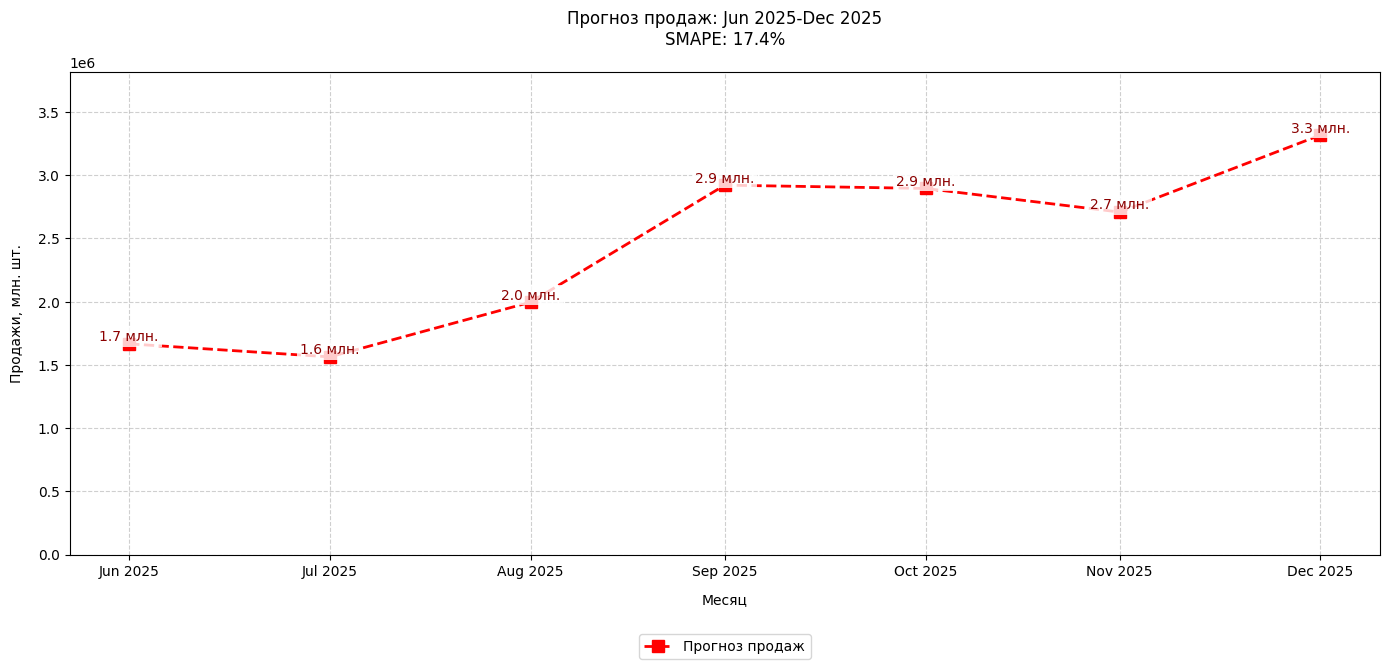


Полный прогноз с июня по декабрь 2025 года:
      Дата   Месяц  Прогноз (млн. шт.)  Нижняя граница  Верхняя граница
2025-06-30 2025-06                 1.7             1.1              2.5
2025-07-31 2025-07                 1.6             1.0              2.4
2025-08-31 2025-08                 2.0             1.3              3.1
2025-09-30 2025-09                 2.9             1.9              4.5
2025-10-31 2025-10                 2.9             1.9              4.4
2025-11-30 2025-11                 2.7             1.8              4.2
2025-12-31 2025-12                 3.3             2.2              5.1


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime
import matplotlib.dates as mdates
from pmdarima import auto_arima

warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff = diff[np.isfinite(diff)]
    return round(np.mean(diff) * 100, 1)

# 1. Загрузка и подготовка данных
df = pd.read_excel('../data/sales.xlsx')
df.columns = ['date', 'item', 'sales']
df['date'] = pd.to_datetime(df['date'])

# Агрегация по месяцам
df_monthly = df.groupby(pd.Grouper(key='date', freq='ME'))['sales'].sum().reset_index()

# Создание полного временного ряда
current_date = datetime.now().strftime("%Y-%m-%d")
last_actual_date = pd.to_datetime(current_date)
full_dates = pd.date_range(start=df_monthly['date'].min(), end=last_actual_date, freq='ME')
df_full = pd.DataFrame({'date': full_dates})
df_full = df_full.merge(df_monthly, on='date', how='left')
df_full['sales'] = df_full['sales'].fillna(0)
df_full = df_full.set_index('date')

# 2. Корректное разделение данных (тренировочные до декабря 2024, тестовые с января 2025)
train_end = pd.to_datetime("2024-12-31")
test_start = pd.to_datetime("2025-01-01")
test_end = last_actual_date

X_train = df_full.loc[:train_end]
X_test = df_full.loc[test_start:test_end] if test_start <= last_actual_date else pd.DataFrame()

# 3. Обучение модели и расчет SMAPE
y_train = np.log1p(X_train['sales'])
model = auto_arima(y_train,
                  seasonal=True,
                  m=12,
                  stepwise=True,
                  trace=True,
                  suppress_warnings=True,
                  error_action='ignore')

print(f"Лучшие параметры модели: {model.order}, {model.seasonal_order}")

if not X_test.empty:
    test_forecast = np.expm1(model.predict(n_periods=len(X_test)))
    smape_score = smape(X_test['sales'], test_forecast)
    print(f"\nSMAPE на тестовом периоде ({X_test.index[0].strftime('%Y-%m')}-{X_test.index[-1].strftime('%Y-%m')}): {smape_score}%")
else:
    smape_score = None

# 4. Переобучение модели на всех данных для финального прогноза
y_full = np.log1p(df_full['sales'])
model_full = auto_arima(y_full,
                      seasonal=True,
                      m=12,
                      stepwise=True,
                      suppress_warnings=True,
                      error_action='ignore')

# 5. Прогнозирование с июня по декабрь 2025
forecast_start = pd.to_datetime("2025-06-01")  # Фиксированное начало прогноза
forecast_end = pd.to_datetime("2025-12-31")
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='ME')
steps = len(forecast_dates)

forecast_result = model_full.predict(n_periods=steps, return_conf_int=True)
forecast_values = np.expm1(forecast_result[0])
conf_int = np.expm1(forecast_result[1])

# Проверка
print(f"\nПроверка дат прогноза: {[d.strftime('%Y-%m') for d in forecast_dates]}")
print(f"Количество значений прогноза: {len(forecast_values)}")

# 6. Визуализация
plt.figure(figsize=(14, 7))

# Точное позиционирование точек (конец каждого месяца)
plot_dates = forecast_dates + pd.offsets.MonthEnd(0)

# Прогноз с маркерами
plt.plot(plot_dates, forecast_values, 'r--s',
        label='Прогноз продаж', linewidth=2, markersize=8)

# Подписи значений
for date, value in zip(plot_dates, forecast_values):
    plt.text(date, value, f'{value/1_000_000:.1f} млн.',
            ha='center', va='bottom', fontsize=10, color='darkred',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

# Настройка оси X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(plot_dates, [date.strftime('%b %Y') for date in forecast_dates])

# Настройки графика
title = f'Прогноз продаж: {forecast_dates[0].strftime("%b %Y")}-{forecast_dates[-1].strftime("%b %Y")}'
if smape_score is not None:
    title += f'\nSMAPE: {smape_score}%'
plt.title(title, pad=20)

plt.xlabel('Месяц', labelpad=10)
plt.ylabel('Продажи, млн. шт.', labelpad=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)
plt.ylim(0, forecast_values.max() * 1.15)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# 7. Результирующая таблица
forecast_df = pd.DataFrame({
    'Дата': forecast_dates.strftime('%Y-%m-%d'),
    'Месяц': forecast_dates.strftime('%Y-%m'),
    'Прогноз (млн. шт.)': (forecast_values/1_000_000).round(1),
    'Нижняя граница': (conf_int[:, 0]/1_000_000).round(1),
    'Верхняя граница': (conf_int[:, 1]/1_000_000).round(1)
})
print("\nПолный прогноз с июня по декабрь 2025 года:")
print(forecast_df.to_string(index=False))